In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [29]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))


In [30]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [31]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)


a =  9.188119888305664
b =  0.6033520698547363


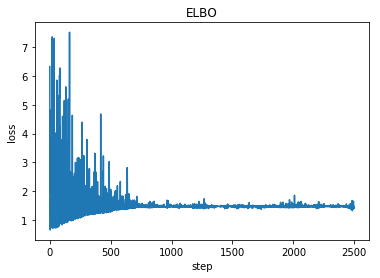

In [36]:
from torch.distributions import constraints

def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs


guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

a =  9.107148170471191
b =  0.606410026550293


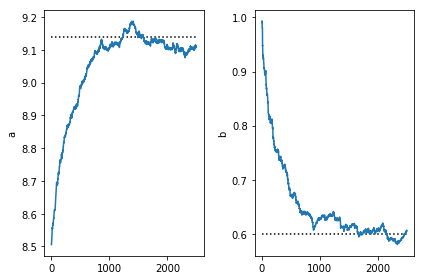

In [35]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [13]:
import argparse
import functools
import logging

import torch
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.optim import ClippedAdam

logging.basicConfig(format='%(relativeCreated) 9d %(message)s', level=logging.INFO)


# This is a fully generative model of a batch of documents.
# data is a [num_words_per_doc, num_documents] shaped array of word ids
# (specifically it is not a histogram). We assume in this simple example
# that all documents have the same number of words.
def model(data=None, args=None, batch_size=None):
    # Globals.
    with pyro.plate("topics", args.num_topics):
        topic_weights = pyro.sample("topic_weights", dist.Gamma(1. / args.num_topics, 1.))
        topic_words = pyro.sample("topic_words",
                                  dist.Dirichlet(torch.ones(args.num_words) / args.num_words))

    # Locals.
    with pyro.plate("documents", args.num_docs) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (args.num_words_per_doc, args.num_docs)
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
        with pyro.plate("words", args.num_words_per_doc):
            # The word_topics variable is marginalized out during inference,
            # achieved by specifying infer={"enumerate": "parallel"} and using
            # TraceEnum_ELBO for inference. Thus we can ignore this variable in
            # the guide.
            word_topics = pyro.sample("word_topics", dist.Categorical(doc_topics),
                                      infer={"enumerate": "parallel"})
            data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]),
                               obs=data)

    return topic_weights, topic_words, data


# We will use amortized inference of the local topic variables, achieved by a
# multi-layer perceptron. We'll wrap the guide in an nn.Module.
def make_predictor(args):
    layer_sizes = ([args.num_words] +
                   [int(s) for s in args.layer_sizes.split('-')] +
                   [args.num_topics])
    logging.info('Creating MLP with sizes {}'.format(layer_sizes))
    layers = []
    for in_size, out_size in zip(layer_sizes, layer_sizes[1:]):
        layer = nn.Linear(in_size, out_size)
        layer.weight.data.normal_(0, 0.001)
        layer.bias.data.normal_(0, 0.001)
        layers.append(layer)
        layers.append(nn.Sigmoid())
    layers.append(nn.Softmax(dim=-1))
    return nn.Sequential(*layers)


def parametrized_guide(predictor, data, args, batch_size=None):
    # Use a conjugate guide for global variables.
    topic_weights_posterior = pyro.param(
            "topic_weights_posterior",
            lambda: torch.ones(args.num_topics),
            constraint=constraints.positive)
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(args.num_topics, args.num_words),
            constraint=constraints.greater_than(0.5))
    with pyro.plate("topics", args.num_topics):
        pyro.sample("topic_weights", dist.Gamma(topic_weights_posterior, 1.))
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    # Use an amortized guide for local variables.
    pyro.module("predictor", predictor)
    with pyro.plate("documents", args.num_docs, batch_size) as ind:
        data = data[:, ind]
        # The neural network will operate on histograms rather than word
        # index vectors, so we'll convert the raw data to a histogram.
        counts = (torch.zeros(args.num_words, ind.size(0))
                       .scatter_add(0, data, torch.ones(data.shape)))
        doc_topics = predictor(counts.transpose(0, 1))
        pyro.sample("doc_topics", dist.Delta(doc_topics, event_dim=1))


def main(args):
    logging.info('Generating data')
    pyro.set_rng_seed(0)
    pyro.clear_param_store()
    pyro.enable_validation(__debug__)

    # We can generate synthetic data directly by calling the model.
    true_topic_weights, true_topic_words, data = model(args=args)

    # We'll train using SVI.
    logging.info('-' * 40)
    logging.info('Training on {} documents'.format(args.num_docs))
    predictor = make_predictor(args)
    guide = functools.partial(parametrized_guide, predictor)
    Elbo = JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO
    elbo = Elbo(max_plate_nesting=2)
    optim = ClippedAdam({'lr': args.learning_rate})
    svi = SVI(model, guide, optim, elbo)
    logging.info('Step\tLoss')
    for step in range(args.num_steps):
        loss = svi.step(data, args=args, batch_size=args.batch_size)
        if step % 10 == 0:
            logging.info('{: >5d}\t{}'.format(step, loss))
    loss = elbo.loss(model, guide, data, args=args)
    logging.info('final loss = {}'.format(loss))


if __name__ == '__main__':
    assert pyro.__version__.startswith('1.0.0')
    parser = argparse.ArgumentParser(description="Amortized Latent Dirichlet Allocation")
    parser.add_argument("-t", "--num-topics", default=8, type=int)
    parser.add_argument("-w", "--num-words", default=1024, type=int)
    parser.add_argument("-d", "--num-docs", default=1000, type=int)
    parser.add_argument("-wd", "--num-words-per-doc", default=64, type=int)
    parser.add_argument("-n", "--num-steps", default=1000, type=int)
    parser.add_argument("-l", "--layer-sizes", default="100-100")
    parser.add_argument("-lr", "--learning-rate", default=0.01, type=float)
    parser.add_argument("-b", "--batch-size", default=32, type=int)
    parser.add_argument('--jit', action='store_true')
    args = parser.parse_args()
    main(args)

('sunny', 105.9779052734375)
('cloudy', 61.45758056640625)
('cloudy', 52.27955627441406)
